In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping
from scipy.fft import fft



In [39]:
# Loading the datasets
accelerometer_data = pd.read_csv('/home/mzero/main/uni_repo/machine_learning_fqs_2024/ml4qs-gesture-recognition/data/preprocced_data/Combined_accelerometer_80min.csv')
gyroscope_data = pd.read_csv('/home/mzero/main/uni_repo/machine_learning_fqs_2024/ml4qs-gesture-recognition/data/preprocced_data/Combined_gyroscope_80min.csv')
linear_accelerometer_data = pd.read_csv('/home/mzero/main/uni_repo/machine_learning_fqs_2024/ml4qs-gesture-recognition/data/preprocced_data/Combined_linear_accelerometer_80min.csv')
magnetometer_data = pd.read_csv('/home/mzero/main/uni_repo/machine_learning_fqs_2024/ml4qs-gesture-recognition/data/preprocced_data/Combined_magnetometer_80min.csv')

### Transformation

###### Normalization

In [40]:
# Merge datasets on time and label columns - syncronizing to same time point.
df = pd.merge(accelerometer_data, gyroscope_data, on=['time', 'label'])
df = pd.merge(data, linear_accelerometer_data, on=['time', 'label'])
df = pd.merge(data, magnetometer_data, on=['time', 'label'])

###### Fourier Transform

In [68]:

# Applying Fast Fourier Transformation - Discrete fourier Transformation
def apply_dft(df):
    features = data.columns.difference(['time', 'label'])
    data[features] = np.abs(fft(data[features], axis=1))
    return data 

print(data)

        time  X (m/s^2)_x  Y (m/s^2)_x  Z (m/s^2)_x  label  X (rad/s)  \
0        0.0     1.733939    -0.896367     0.016498      1  -0.539965   
1        0.5     0.763584    -0.988776     0.016498      1   0.084789   
2        1.0     1.512179    -1.536550     0.041550      1   0.489120   
3        1.5     1.512179    -2.128818     0.086338      1   0.015057   
4        2.0     1.734644    -2.128818     0.076241      1   0.026014   
...      ...          ...          ...          ...    ...        ...   
9555  4778.5    -0.733261     0.361888    -1.007100      3  -0.077005   
9556  4779.0    -1.063897     0.182743    -0.879866      3   0.158117   
9557  4779.5    -1.081024     0.051991    -1.053849      3  -0.042638   
9558  4780.0    -0.823861     0.331053    -0.895031      3  -0.028311   
9559  4780.5    -0.253258     0.643179    -1.073786      3   0.285706   

      Y (rad/s)  Z (rad/s)  X (m/s^2)_y  Y (m/s^2)_y  Z (m/s^2)_y    X (µT)  \
0     -0.733322   0.888424     0.387696     

In [69]:
# Normalize the feature columns
features = data.columns.difference(['time', 'label'])
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

In [70]:
# Verify the unique classes
print(f"Classes: {label_encoder.classes_}")
print(f"Number of classes: {label_encoder.classes_.shape[0]}")

Classes: [0 1 2 3]
Number of classes: 4


In [71]:
# Reshape the data - DOCUMENTED AS THE WAY TO PASS DATA TO THE LSTM NEEDS TO BE A SEQUENCE to learn the temporal patterns matching sequence to label 
time_steps = 50  # Number of time steps to look back for predictions - ANDOMLY CHOSEN O RATIONAL YET
X = []
y = []

for i in range(time_steps, len(data)):
    X.append(data.iloc[i-time_steps:i][features].values)
    y.append(data.iloc[i]['label'])


X, y = np.array(X), np.array(y)

### Long Short-term Memory Model Implimentation

In [72]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [73]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6657, 50, 12)
(2853, 50, 12)
(6657,)
(2853,)


In [76]:
# LSTM Development Still working out what is required, but apperantly order matters. 

model = Sequential() # Model to store layers 
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) # First LSTM Layer
model.add(Dropout(0.2)) # Droput 20% of the neurons for overfitting
model.add(LSTM(units=50))# add 50 more neuons in second layer to pass to the final layer
model.add(Dense(units=label_encoder.classes_.shape[0], activation='softmax')) # Final output layer with predictions

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

/home/mzero/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [77]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Stop process once there is no improvement
training = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.5)

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7077 - loss: 0.8219 - val_accuracy: 0.9567 - val_loss: 0.1681
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9741 - loss: 0.1082 - val_accuracy: 0.9778 - val_loss: 0.0757
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9795 - loss: 0.0773 - val_accuracy: 0.9904 - val_loss: 0.0401
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9896 - loss: 0.0415 - val_accuracy: 0.9883 - val_loss: 0.0388
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9870 - loss: 0.0468 - val_accuracy: 0.9922 - val_loss: 0.0286
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9962 - loss: 0.0236 - val_accuracy: 0.9946 - val_loss: 0.0196
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9968 - loss: 0.0163 - val_accuracy: 0.9946 - val_loss: 0.0155
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9955 - loss: 0.0213 - val_accu

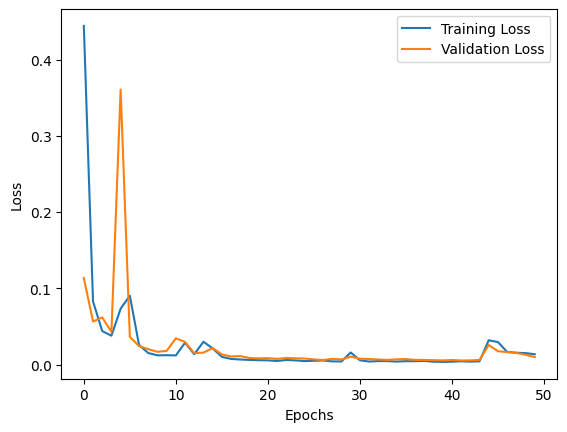

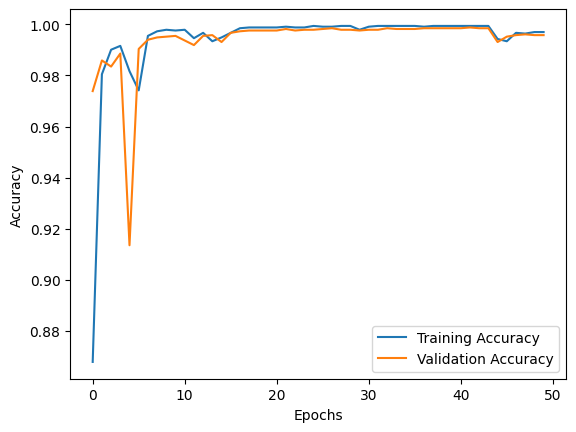

In [79]:
# Plot learning curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [78]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9989 - loss: 0.0045
Test Accuracy: 0.9989
